Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.
Modified by Shohei Nagata.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/ml-frameworks/pytorch/distributed-pytorch-with-horovod/distributed-pytorch-with-horovod.png)

# PyTorchモデルでの画像分類
本日のハンズオンでは[MNIST](http://yann.lecun.com/exdb/mnist/)データセットを対象に画像分類を行うPyTorchモデルを学習します。

## Prerequisites
Azure Machine Learning Notebook VMを使用している場合は、すべての設定が完了しています。
GPUインスタンスを使用する場合は事前にクォーター申請が必要となる場合があります。

参考：[Azure Machine Learning を使用するリソースのクォータの管理と引き上げ](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-manage-quotas)、
[申請手順](https://docs.microsoft.com/ja-jp/azure/azure-portal/supportability/regional-quota-requests#request-a-quota-increase-by-region-from-help--support)

In [ ]:
# Azure ML SDKのバージョン確認
import azureml.core

print("SDK version:", azureml.core.VERSION)

## Diagnostics
Opt-in diagnostics for better experience, quality, and security of future releases.

In [ ]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

## ワークスペースの設定
Azure ML ワークスペースによってAzure MLで使用するアセット類 (データ、スクリプト、出力、等々)を管理していきます。
![](https://docs.microsoft.com/ja-jp/azure/machine-learning/media/concept-azure-machine-learning-architecture/architecture.svg)

`Workspace.from_config()` は、`config.json` に格納された詳細情報から、ワークスペース・オブジェクトを作成します。   

事前にAzure ML Studioから構成ファイル (config.json)をダウンロードし、本スクリプトと同一階層に置きます。  

初回実行時は認証を行う必要があるため、実行結果部分の指示に従って https://microsoft.com/devicelogin にアクセスし、認証コードを入力します。

In [ ]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

## 計算環境の準備

モデルをトレーニングするためには、[コンピューティング先](hhttps://docs.microsoft.com/ja-jp/azure/machine-learning/concept-azure-machine-learning-architecture#computes)を作成する必要があります。このノートブックでは、コンピューティング クラスターをリモートトレーニング用のコンピュートリソースとして使用します。  
具体的には，以下のコードで，`STANDARD_NC6`のGPUクラスターを作成し，`0`から`2`のノードにオートスケールします。

> Azure ML データサイエンティストのロールのみを持っている場合、コンピュートリソースを作成する権限はありませんのでご注意ください。このセクションで説明するコンピュートターゲットがまだ存在していない場合は、ワークスペースまたはIT管理者に相談して作成してください。

**コンピューティングクラスターの作成には約5分かかります。** 同一名称のものがワークスペースにある場合、下記コードは作成プロセスをスキップします。



In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "cpu-cluster-ds13"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_DS13_v2',
                                                           max_nodes=2)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current AmlCompute. 
print(compute_target.get_status().serialize())

上記のコードでは，GPUコンピュートを作成しています．代わりにCPUコンピュートを作成したい場合は、`Standard_DS13_v2`のように、`vm_size`パラメータに異なるVMサイズを指定してください。

## リモートでのモデル学習 
リモート (Azure ML上の)計算環境が準備できたので、学習ジョブを実行してみましょう。

### プロジェクトディレクトリの作成
ローカルマシンからリモートリソースにアクセスするために必要なコードをすべて格納するディレクトリを作成します。このディレクトリには、トレーニングスクリプトと、トレーニングスクリプトが依存する追加ファイルが含まれます。

In [ ]:
import os

project_folder = './pytorch-mnist'
os.makedirs(project_folder, exist_ok=True)

### トレーニングスクリプトの準備
ここでは、トレーニング用のスクリプトを作成します。本コンテンツでは、MNISTの分散学習用のスクリプトを`pytorch_mnist.py`で用意しています。  
(これは [PyTorch公式のMNISTサンプル](https://github.com/pytorch/examples/blob/master/mnist/main.py)をベースにログ記録を追加したものです)  
実際には、カスタムのPyTorchトレーニングスクリプトをそのまま使用して、コードを変更することなくAzure MLで実行することが可能です。

Azure MLの[ログ記録](https://docs.microsoft.com/ja-jp/azure/machine-learning/concept-azure-machine-learning-architecture#logging)機能を使いたい場合は、トレーニングスクリプト内に少量のAzure MLロジックを追加する必要があります。この例では、ロギング間隔ごとに、そのミニバッチの損失をAzure ML Runにロギングします。

これを行うために、`pytorch_mnist.py`では、まずスクリプト内にAzure MLの`Run`オブジェクトへのアクセスを追加しています。
```Python
from azureml.core.run import Run
run = Run.get_context()
```
そしてスクリプトの後半で、損失メトリックを Run に記録します。
```Python
run.log('loss', loss.item())
```

トレーニングスクリプト `pytorch_mnist.py`をプロジェクトディレクトリ内へコピーします。

In [ ]:
import shutil

shutil.copy('pytorch_mnist.py', project_folder)

### 実験の作成
[実験 (Experiment)](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment)を作成して、このPyTorchチュートリアルのワークスペースでのすべての実行を追跡します。

In [ ]:
from azureml.core import Experiment

experiment_name = 'pytorch-mnist'
experiment = Experiment(ws, name=experiment_name)

### 環境の作成

Azure MLではいくつかの[キュレートされた実行環境](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-use-environments#use-a-curated-environment)が用意されています。
今回はPyTorch 1.6 GPU環境を使用します。こちらのキュレートされた環境には今回のトレーニングスクリプトで必要なtorch, torchvisionも含まれています。

参考：[キュレーションされた環境一覧](https://docs.microsoft.com/ja-jp/azure/machine-learning/resource-curated-environments)

In [ ]:
from azureml.core import Environment

pytorch_env = Environment.get(ws, name='AzureML-PyTorch-1.6-GPU')

In [ ]:
# 中身の確認
print(pytorch_env.python.conda_dependencies.serialize_to_string())

### トレーニングジョブの設定
`ScriptRunConfig`を用いてスクリプトの実行構成を作成します。
![](../img/scriptrunconfig.png)

参考：[スクリプトの実行構成を作成する](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-set-up-training-targets#create-the-script-run-configuration)

In [ ]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(source_directory=project_folder,
                      script='pytorch_mnist.py',
                      compute_target=compute_target,
                      environment=pytorch_env)

### トレーニングジョブの実行 (送信)
前項の`ScriptRunConfig`で設定した条件に基づいて実験を実行 (送信)します。

In [ ]:
run = experiment.submit(src)
print(run)

### モニタリング
Jupyterウィジェットを使って実行の進捗状況を監視することができます。実行のサブミッションと同様に、ウィジェットは非同期で、ジョブが完了するまで10～15秒ごとに自動で更新されます。ウィジェットでは、Azure MLの実行に記録した損失指標が自動的に表示・可視化されます。

※VSCode上で実行する場合、テーマ設定 (背景色)によってはAzure MLウィジェットが見えにくくなる可能性があります。その場合はLightテーマの使用をお勧めします。

In [ ]:
from azureml.widgets import RunDetails

RunDetails(run).show()

Alternatively, you can block until the script has completed training before running more code.

In [ ]:
run.wait_for_completion(show_output=True) # this provides a verbose log

## モデルの登録

In [ ]:
#実行に関係しているファイル一覧の表示
for i in run.get_file_names():
    print(i)

In [ ]:
model = run.register_model(model_name = 'pytorch-mnist', model_path = 'outputs/mnist_cnn.pt')
print(model.name, model.id, model.version, sep = '\t')

## モデルデプロイ
Azure Container Instances (ACI) にモデルをWebサービスとしてモデルをデプロイしていきます。  
参考：[Azure Container Instances とは](https://docs.microsoft.com/ja-jp/azure/container-instances/container-instances-overview)

### スコアリングスクリプトの作成
Web サービスの呼び出しに使用される score.py というスコアリング スクリプトを作成してモデルの使用方法を示します。
スコアリング スクリプトには、2 つの必要な関数を含める必要があります。
- `init()` 関数。通常、グローバル オブジェクトにモデルを読み込みます。 この関数は、Docker コンテナーを開始するときに 1 回だけ実行されます。
- `run(input_data)` 関数。モデルを使用して、入力データに基づく値を予測します。 実行に対する入力と出力は、通常、JSON を使用してシリアル化およびシリアル化解除が実行されますが、その他の形式もサポートされています。

In [ ]:
%%writefile score_pytorch_mnist.py
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision import transforms

#from azureml.core.model import Model


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'mnist_cnn.pt')
    model = Net()
    model.load_state_dict(
        torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()


def run(input_data):
    input_data = torch.tensor(json.loads(input_data)['data'])

    # get prediction
    with torch.no_grad():
        input_data = input_data.unsqueeze(0)  # add batch dimension
        output = model(input_data)
        softmax = nn.Softmax(dim=1)
        pred_probs = softmax(output).numpy()[0]
        index = torch.argmax(output, 1)

    result = {"label": index, "probability": str(pred_probs[index])}
    return result

### ACIコンテナへのデプロイ
デプロイの構成ファイルを作成し、ACI コンテナーに必要な CPU 数と RAM ギガバイト数を指定します。 実際のモデルにもよりますが、通常、多くのモデルには既定値の 1 コアと 1 ギガバイトの RAM で十分です。 後でもっと必要になった場合は、イメージを再作成し、サービスをデプロイし直す必要があります。
※今回はデプロイ先の実行環境にはトレーニング時と同一の環境を使用しています。

In [ ]:
%%time
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

#推論スクリプト・環境の指定
inference_config = InferenceConfig(entry_script="score_pytorch_mnist.py", environment=pytorch_env) # 学習時と同じ環境を使用

#デプロイの構成設定
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'mnist',  'model':'pytorch-mnist', 'framework':'pytorch'},
                                               description='Classify handwritten digits from the MNIST dataset using PyTorch')

model = Model(ws, 'pytorch-mnist')

service = Model.deploy(workspace=ws, 
                           name='aci-mnist', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig,
                           overwrite=True)

service.wait_for_deployment(show_output=True)
print(service.state)

In [ ]:
# # デプロイ中に問題が発生した場合にログ取得
# service.get_logs()

In [ ]:
# # 再デプロイ前に既存のACIサービスを削除
# service.delete()

## Webサービスのテスト
最後に、デプロイしたWebサービスをテストしてみましょう。ACIにホストされているWebサービスにJSON文字列としてデータを送信し、SDKのrun APIを使ってサービスを呼び出してみます。ここでは、検証データから画像を取り出して予測を行います。

In [ ]:
# # 既存のACIWebサービスを取得する場合. serviceを定義する。
# from azureml.core.workspace import Workspace
# from azureml.core.webservice import AciWebservice
# ws = Workspace.from_config()
# service = AciWebservice(workspace=ws, name='aci-mnist')

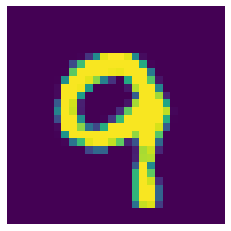

9


In [5]:
# MNIST データセット内のテスト画像を用いて推論を行う
import json
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

datasets.MNIST.resources = [
    ("https://azureopendatastorage.azurefd.net/mnist/train-images-idx3-ubyte.gz",
        "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
    ("https://azureopendatastorage.azurefd.net/mnist/train-labels-idx1-ubyte.gz",
        "d53e105ee54ea40749a09fcbcd1e9432"),
    ("https://azureopendatastorage.azurefd.net/mnist/t10k-images-idx3-ubyte.gz",
        "9fb629c4189551a2d022fa330f9573f3"),
    ("https://azureopendatastorage.azurefd.net/mnist/t10k-labels-idx1-ubyte.gz",
        "ec29112dd5afa0611ce80d1b7f02629c")
]

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))]
    )
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)
image_tensor, target_class = test_dataset[99] #数字で対象画像を指定
image_np = image_tensor.to('cpu').detach().numpy()
input_data = image_np

# plot image
plt.axis('off')
plt.imshow(image_tensor.permute(1, 2, 0))
plt.show()
print(target_class)

In [ ]:
# ACIへ送信して推論実行
result = service.run(input_data=json.dumps({'data': input_data.tolist()}))
print(result)

## クリーンアップ
最後に、デプロイされたWebサービスを削除します。

In [ ]:
# (コメントアウトを解除してください)
# service.delete()